In [1]:
import lib.display
import numpy as np
import pandas as pd
import seaborn as sns
import os
import re

import joblib

from sklearn.ensemble import RandomForestClassifier

from matplotlib import pyplot as plt
from matplotlib import animation
from skimage import transform
from tqdm.auto import tqdm
from IPython.display import HTML, clear_output
import ipywidgets as widgets

from math import floor

In [3]:
import rpy2
from rpy2.robjects import numpy2ri
from rpy2.robjects import pandas2ri
numpy2ri.activate()
pandas2ri.activate()
%load_ext rpy2.ipython

In [2]:
logfile = '/Users/weinberz/Desktop/OPP_scramble.log'
basedir = '/Users/weinberz/UM Drive/50Hz Puffs/Analysis/OPP'
files = os.listdir(basedir)
excludes = ['0IYVHRNA','19CC75ZU','2TZWB6CN','3W70AV4V']
movies_list = [f for f in files if 'features' in f]
movies_list = [m for m in movies_list if m.split('.')[0] not in excludes]

FileNotFoundError: [Errno 2] No such file or directory: '/Users/weinberz/UM Drive/50Hz Puffs/Analysis/OPP'

In [9]:
def get_cargo_id(cell, logfile):
    content = open(logfile,'r').read()

    p = re.compile("(tfr|b2|mor).*"+cell+".*?\n")
    res = p.search(content)
    if res is not None:
        if res.group(1) == 'b2':
            return('B2')
        elif res.group(1) == 'mor':
            return('MOR')
        elif res.group(1) == 'tfr':
            return('TfR')
    
    raise NameError('Cell name not found in logfile.')

# Unlabeled Sample

In [4]:
features_list = []
for movie in movies_list:
    cell = movie.split('_')[0]
    features = pd.read_csv(basedir + os.sep + movie, index_col=0)
    features.loc[:, 'cell'] = cell
    features.loc[:, 'cargo'] =  get_cargo_id(cell, logfile)
    features_list.append(features)
    
sample = pd.concat(features_list, ignore_index=True)

In [6]:
training_fields = ['conv_perim', 'conv_area', 'lifetime_s',
    'randomness_s1', 'randomness_s2', 'cc11', 'cc12', 'cc13', 'cc21',
    'cc22', 'cc23', 'deltaf', 'tau', 'resid_dist', 'residuals_median',
    'residuals_std', 'snr_median', 'snr_std']

classifier = joblib.load('global_classifier.joblib')
new_pred_probs = np.zeros(len(sample))
ww = (1 - np.mean(labeled_sample['puff']))/np.mean(labeled_sample['puff'])
for tt in classifier.estimators_:
    tree_pred = tt.predict_proba(sample[training_fields])[:,1]
    new_pred_probs = new_pred_probs + tree_pred/(tree_pred + ww - ww*tree_pred)
new_pred_probs /= (1.0*len(classifier.estimators_))
sample['adj_proba'] = new_pred_probs

In [12]:
np.random.seed(237)
bins = [[0, 0.1], [0.1, 0.2], [0.2, 0.3], [0.3, 0.4], [0.4, 0.5], [0.5, 0.6], [0.6, 0.7], [0.7, 0.8], [0.8, 0.9], [0.9, 1.0]]
n_samples = [36,  64,  84,  96, 100, 100,  96,  84,  64,  36]

In [13]:
binned_samples = []
for cargo in sample['cargo'].unique():
    cargo_sample = sample[sample['cargo']==cargo]
    for idx, bin_ in enumerate(bins):
        binned_sample = cargo_sample[(bin_[0] <= cargo_sample['adj_proba'].values) &
                                     (cargo_sample['adj_proba'].values < bin_[1])]
        replacement = len(binned_sample) < n_samples[idx]
        binned_sample = binned_sample.iloc[np.random.choice(len(binned_sample), size=n_samples[idx], replace=replacement)]
        binned_samples.append(binned_sample[['cell', 'particle', 'adj_proba', 'cargo']])

binned_samples = pd.concat(binned_samples, ignore_index = True)
binned_samples['score'] = None

In [64]:
np.random.seed(237)
subsample = binned_samples.loc[~(binned_samples['score'] >= 0), :]
cell_label = widgets.Label(value='')
particle_label = widgets.Label(value='')
labels = widgets.HBox([cell_label, particle_label])

centered_layout = widgets.Layout(align_items = 'center')

loading_widget = widgets.Label(value='Loading...')

puff_butt = widgets.Button(description='Puff!',
                           disabled=False,
                           button_style='',
                           tooltips='Puff',
                           icons='check')
np_butt = widgets.Button(description='Nonpuff!',
                           disabled=False,
                           button_style='',
                           tooltips='Nonpuff',
                           icons='times')
score_butt = widgets.HBox([np_butt, puff_butt])

header = widgets.VBox([labels, score_butt], layout=centered_layout)
summary_display = widgets.HBox([loading_widget])
full_display = widgets.VBox([header, summary_display], layout=centered_layout)
display(full_display)

def load_next_cell():
    global events
    global cells
    
    cell = next(cells, None)
    if cell is None:
        loading_widget.value = "You're done! Time to go home!"
        summary_display.children = [loading_widget]
    else:
        loading_widget.value = "Getting new cell..."
        summary_display.children = [loading_widget]
        cell_label.value = cell
        intensities = pd.read_csv(basedir + os.sep + cell + '_intensities.csv')
        events = [intensities.loc[intensities['particle'] == particle, :]
                  for particle in subsample.loc[subsample['cell'] == cell_label.value, 'particle'].unique()]
        np.random.shuffle(events)
        events = iter(events)

def display_and_load():
    global events
    
    event = next(events, None)
    if event is None:
        load_next_cell()
        event = next(events)
    
    loading_widget.value = ("Loading event with length %d..." % len(event['frame'].unique()))
    summary_display.children = [loading_widget]
    particle = event['particle'].values[0]
    particle_label.value = str(particle)
    summary_widgets = lib.display.plot_summary(event)
    summary_display.children = [widgets.VBox([widgets.HBox(summary_widgets[:2]), 
                                             summary_widgets[2]], layout=centered_layout)]

def call_puff(b):
    binned_samples.loc[(binned_samples['particle'] == int(particle_label.value)) &
                       (binned_samples['cell'] == cell_label.value), 'score'] = 1
    display_and_load()

def call_np(b):
    binned_samples.loc[(binned_samples['particle'] == int(particle_label.value)) &
                       (binned_samples['cell'] == cell_label.value), 'score'] = 0
    display_and_load()

puff_butt.on_click(call_puff)
np_butt.on_click(call_np)

cells = [cell for cell in subsample['cell'].unique()]
np.random.shuffle(cells)
cells = iter(cells)
events = iter(())

display_and_load()

In [36]:
binned_samples = pd.read_csv('scored_binned_samples-20191121.csv', index_col=0)#
#binned_samples.to_csv('scored_binned_samples-20191121.csv')

In [37]:
np.sum(binned_samples['score']>=0)

2280

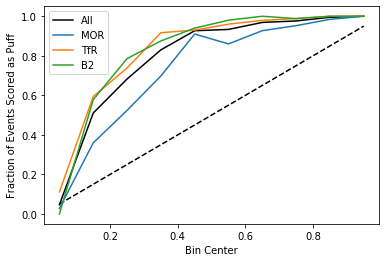

In [38]:
plt.figure()
xs = [res for res in map(np.mean, bins)]
plt.plot(xs, xs, linestyle='--', color='k')

ys = []
for idx, bin_ in enumerate(bins):
    binned_sample = binned_samples[(bin_[0] <= binned_samples['adj_proba'].values) &
                                   (binned_samples['adj_proba'].values < bin_[1])]
    ys.append(np.sum(binned_sample['score'] == 1)/np.sum(binned_sample['score'] >= 0))
plt.plot(xs, ys, label='All', color='k')

for cargo in binned_samples['cargo'].unique():
    ys = []
    for idx, bin_ in enumerate(bins):
        binned_sample = binned_samples[(bin_[0] <= binned_samples['adj_proba'].values) &
                                       (binned_samples['adj_proba'].values < bin_[1]) &
                                       (binned_samples['cargo'] == cargo)]
        ys.append(np.sum(binned_sample['score'] == 1)/np.sum(binned_sample['score'] >= 0))
    plt.plot(xs, ys, label=cargo)
    
plt.legend()
plt.xlabel('Bin Center')
plt.ylabel('Fraction of Events Scored as Puff')
plt.show()

# Labeled Sample

In [7]:
labeled_dir = 'data'

In [3]:
files = os.listdir(labeled_dir)
labeled_sample = pd.read_csv('labeled_sample-adj_proba.csv', index_col=0)

In [6]:
logfile = '/Volumes/Coatamer/Users/weinberz/UM Drive/OPP/OPP_scramble.log'
labeled_sample['cargo'] = [get_cargo_id(cell, logfile) for cell in labeled_sample['cell']]

In [22]:
np.random.seed(237)
bins = [[0, 0.1], [0.1, 0.2], [0.2, 0.3], [0.3, 0.4], [0.4, 0.5], [0.5, 0.6], [0.6, 0.7], [0.7, 0.8], [0.8, 0.9], [0.9, 1.0]]
n_samples = [36,  64,  84,  96, 100, 100,  96,  84,  64,  36]

In [9]:
binned_labeled_samples = []
for cargo in labeled_sample['cargo'].unique():
    cargo_sample = labeled_sample[labeled_sample['cargo']==cargo]
    for idx, bin_ in enumerate(bins):
        binned_sample = cargo_sample[(bin_[0] <= cargo_sample['adj_proba'].values) &
                                     (cargo_sample['adj_proba'].values < bin_[1])]
        replacement = len(binned_sample) < n_samples[idx]
        binned_sample = binned_sample.iloc[np.random.choice(len(binned_sample), size=n_samples[idx], replace=replacement)]
        binned_labeled_samples.append(binned_sample[['cell', 'particle', 'adj_proba', 'cargo']])

binned_labeled_samples = pd.concat(binned_labeled_samples, ignore_index = True)
binned_labeled_samples['score'] = None

In [8]:
np.random.seed(237)
subsample = binned_labeled_samples.loc[~(binned_labeled_samples['score'] >= 0), :]
cell_label = widgets.Label(value='')
particle_label = widgets.Label(value='')
labels = widgets.HBox([cell_label, particle_label])

centered_layout = widgets.Layout(align_items = 'center')

loading_widget = widgets.Label(value='Loading...')

puff_butt = widgets.Button(description='Puff!',
                           disabled=False,
                           button_style='',
                           tooltips='Puff',
                           icons='check')
np_butt = widgets.Button(description='Nonpuff!',
                           disabled=False,
                           button_style='',
                           tooltips='Nonpuff',
                           icons='times')
score_butt = widgets.HBox([np_butt, puff_butt])

header = widgets.VBox([labels, score_butt], layout=centered_layout)
summary_display = widgets.HBox([loading_widget])
full_display = widgets.VBox([header, summary_display], layout=centered_layout)
display(full_display)

def load_next_cell():
    global events
    global cells
    
    cell = next(cells, None)
    if cell is None:
        loading_widget.value = "You're done! Time to go home!"
        summary_display.children = [loading_widget]
    else:
        loading_widget.value = "Getting new cell..."
        summary_display.children = [loading_widget]
        cell_label.value = cell
        intensities = pd.read_csv(labeled_dir + os.sep + cell + '_intensities.csv')
        events = [intensities.loc[intensities['particle'] == particle, :]
                  for particle in subsample.loc[subsample['cell'] == cell_label.value, 'particle'].unique()]
        np.random.shuffle(events)
        events = iter(events)

def display_and_load():
    global events
    
    event = next(events, None)
    if event is None:
        load_next_cell()
        event = next(events)
    
    loading_widget.value = ("Loading event with length %d..." % len(event['frame'].unique()))
    summary_display.children = [loading_widget]
    particle = event['particle'].values[0]
    particle_label.value = str(particle)
    summary_widgets = lib.display.plot_summary(event)
    summary_display.children = [widgets.VBox([widgets.HBox(summary_widgets[:2]), 
                                             summary_widgets[2]], layout=centered_layout)]

def call_puff(b):
    binned_labeled_samples.loc[(binned_labeled_samples['particle'] == int(particle_label.value)) &
                       (binned_labeled_samples['cell'] == cell_label.value), 'score'] = 1
    display_and_load()

def call_np(b):
    binned_labeled_samples.loc[(binned_labeled_samples['particle'] == int(particle_label.value)) &
                       (binned_labeled_samples['cell'] == cell_label.value), 'score'] = 0
    display_and_load()

puff_butt.on_click(call_puff)
np_butt.on_click(call_np)

cells = [cell for cell in subsample['cell'].unique()]
np.random.shuffle(cells)
cells = iter(cells)
events = iter(())

display_and_load()

In [31]:
#binned_labeled_samples = pd.read_csv('binned_labeled_samples_20191121.csv', index_col=0)
binned_labeled_samples.to_csv('binned_labeled_samples_20191121.csv')

In [32]:
np.sum(binned_labeled_samples['score'] >= 0)

2280

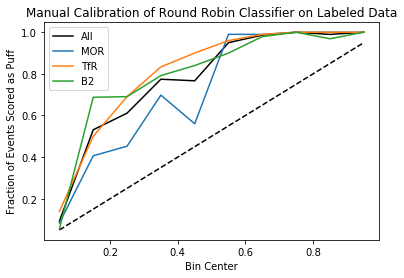

In [35]:
plt.figure()
xs = [res for res in map(np.mean, bins)]
plt.plot(xs, xs, linestyle='--', color='k')

ys = []
for idx, bin_ in enumerate(bins):
    binned_sample = binned_labeled_samples[(bin_[0] <= binned_labeled_samples['adj_proba'].values) &
                                   (binned_labeled_samples['adj_proba'].values < bin_[1])]
    ys.append(np.sum(binned_sample['score'] == 1)/np.sum(binned_sample['score'] >= 0))
plt.plot(xs, ys, label='All', color='k')

for cargo in binned_labeled_samples['cargo'].unique():
    ys = []
    for idx, bin_ in enumerate(bins):
        binned_sample = binned_labeled_samples[(bin_[0] <= binned_labeled_samples['adj_proba'].values) &
                                       (binned_labeled_samples['adj_proba'].values < bin_[1]) &
                                       (binned_labeled_samples['cargo'] == cargo)]
        ys.append(np.sum(binned_sample['score'] == 1)/np.sum(binned_sample['score'] >= 0))
    plt.plot(xs, ys, label=cargo)
    
plt.legend()
plt.xlabel('Bin Center')
plt.ylabel('Fraction of Events Scored as Puff')
plt.title('Manual Calibration of Round Robin Classifier on Labeled Data')
plt.show()

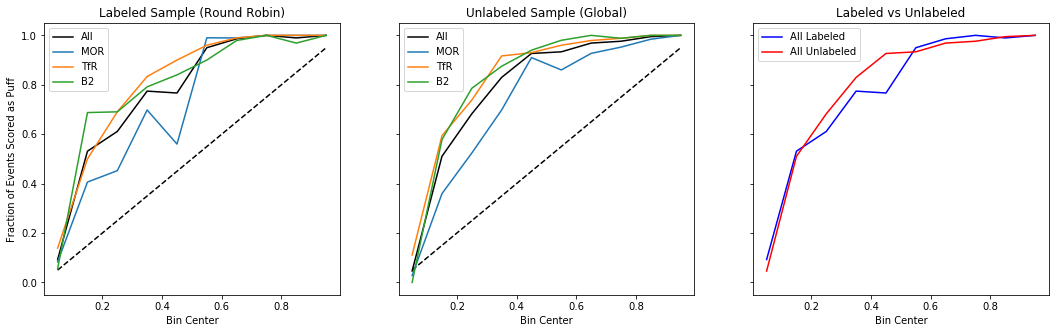

In [45]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,5), sharey=True)

xs = [res for res in map(np.mean, bins)]

for ax, samples in zip(axs, [binned_labeled_samples, binned_samples]):
    ax.plot(xs, xs, linestyle='--', color='k')

    ys = []
    for idx, bin_ in enumerate(bins):
        binned_sample = samples[(bin_[0] <= samples['adj_proba'].values) &
                                       (samples['adj_proba'].values < bin_[1])]
        ys.append(np.sum(binned_sample['score'] == 1)/np.sum(binned_sample['score'] >= 0))
    ax.plot(xs, ys, label='All', color='k')

    for cargo in samples['cargo'].unique():
        ys = []
        for idx, bin_ in enumerate(bins):
            binned_sample = samples[(bin_[0] <= samples['adj_proba'].values) &
                                           (samples['adj_proba'].values < bin_[1]) &
                                           (samples['cargo'] == cargo)]
            ys.append(np.sum(binned_sample['score'] == 1)/np.sum(binned_sample['score'] >= 0))
        ax.plot(xs, ys, label=cargo)

    ax.set_xlabel('Bin Center')
    ax.legend()

labeled_ys = []
unlabeled_ys = []
for idx, bin_ in enumerate(bins):
    labeled_sample = binned_labeled_samples[(bin_[0] <= binned_labeled_samples['adj_proba'].values) &
                                   (binned_labeled_samples['adj_proba'].values < bin_[1])]
    labeled_ys.append(np.sum(labeled_sample['score'] == 1)/np.sum(labeled_sample['score'] >= 0))
    
    unlabeled_sample = binned_samples[(bin_[0] <= binned_samples['adj_proba'].values) &
                                   (binned_samples['adj_proba'].values < bin_[1])]
    unlabeled_ys.append(np.sum(unlabeled_sample['score'] == 1)/np.sum(unlabeled_sample['score'] >= 0))

axs[2].plot(xs, labeled_ys, label='All Labeled', color='b')
axs[2].plot(xs, unlabeled_ys, label='All Unlabeled', color='r')
axs[2].set_xlabel('Bin Center')
axs[0].set_ylabel('Fraction of Events Scored as Puff')
    
axs[0].set_title('Labeled Sample (Round Robin)')
axs[1].set_title('Unlabeled Sample (Global)')
axs[2].set_title('Labeled vs Unlabeled')
axs[2].legend()
plt.show()

# Calibration and Resampling

In [15]:
# The following model was generated using Ciaran's calibration_fit_and_sampling.R script
rpy2.robjects.r("library(scam)")
rpy2.robjects.r("cal_gam <- readRDS('cal_gam.RDS')")

R object with classes: ('scam', 'glm', 'lm') mapped to:
<ListVector - Python:0x1c3afe7ac8 / R:0x7fc21a7698f0>
[FloatVector, FloatVector, FloatVector, StrVector, ..., IntVector, FloatVector, ListVector, StrVector]
  gcv.ubre: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x1c3b6b94c8 / R:0x7fc21f929558>
[-0.358479]
  dgcv.ubre: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x1c3b6b9708 / R:0x7fc2245e34c8>
[0.004508, -0.000004, -0.000007]
  aic: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x1c3b6b9f88 / R:0x7fc21f929590>
[1191.304907]
  optimizer: <class 'rpy2.robjects.vectors.StrVector'>
  R object with classes: ('character',) mapped to:
<StrVector - Python:0x1c3afe7948 / R:0x7fc21f9295c8>
['bfgs']
...
  n.smooth: <class 'rpy2.robjects.vectors.IntVector'>
  R object with classes: ('integer',) mapped to:
<IntVector - Python:0x1c3aebb648 / R:0x7fc21e838570>
[1]
  formula: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('proc_time',) mapped to:
<FloatVector - Python:0x1c3aebbe88 / R:0x7fc224630a88>
[1.505000, 0.226000, 1.736000, 0.000000, 0.000000]
R object with classes: ('scam', 'glm', 'lm') mapped to:
<ListVector - Python:0x1c3afe7ac8 / R:0x7fc21a7698f0>
[FloatVector, FloatVector, FloatVector, StrVector, ..., IntVector, FloatVector, ListVector, StrVector]
  smooth: <class 'rpy2.robjects.vectors.StrVector'>
  R object with classes: ('character',) mapped to:
<StrVector - Python:0x1c3aebb388 / R:0x7fc21e8386f8>
['UBRE']

In [7]:
labeled_samples = pd.read_csv('labeled_sample-adj_proba.csv', index_col=0)
binned_labeled_samples = pd.read_csv('binned_labeled_samples_20191121.csv', index_col=0)

In [11]:
logfile = '/Users/weinberz/Desktop/OPP_scramble.log'
labeled_samples['cargo'] = [get_cargo_id(cell, logfile) 
                            for cell in labeled_samples['cell'].values]

In [16]:
%%R -i labeled_samples
eval_data <- data.frame(cargo = labeled_samples$cargo,
                        adj_proba = labeled_samples$adj_proba)
cal_prob <- predict(cal_gam, 
                   newdata = eval_data,
                   type="response")

In [21]:
labeled_samples['cal_proba'] = numpy2ri.ri2py(rpy2.robjects.globalenv['cal_prob'])

In [22]:
labeled_samples.to_csv('labeled_sample-cal_proba.csv')

In [42]:
binned_labeled_samples['cal_proba'] = [labeled_samples.loc[(labeled_samples['cell'] == cell) &
                                                           (labeled_samples['particle'] == particle),'cal_proba'].values[0]
                                       for cell, particle in binned_labeled_samples[['cell','particle']].itertuples(index=False,name=None)]

In [31]:
np.random.seed(237)
bins = [[0, 0.1], [0.1, 0.2], [0.2, 0.3], [0.3, 0.4], [0.4, 0.5], [0.5, 0.6], [0.6, 0.7], [0.7, 0.8], [0.8, 0.9], [0.9, 1.0]]
n_samples = [36,  64,  84,  96, 100, 100,  96,  84,  64,  36]

In [76]:
redrawn_labeled_samples = []
for cargo in ['MOR','B2', 'TfR']:
    scored_cargo_sample = binned_labeled_samples[binned_labeled_samples['cargo']== cargo]
    unscored_cargo_sample = labeled_samples[labeled_samples['cargo']==cargo]
    for idx, bin_ in enumerate(bins):
        binned_sample = scored_cargo_sample[(bin_[0] <= scored_cargo_sample['cal_proba'].values) &
                                            (scored_cargo_sample['cal_proba'].values < bin_[1])]
        if len(binned_sample) >= n_samples[idx]:
            binned_sample = binned_sample.iloc[np.random.choice(len(binned_sample), size=n_samples[idx], replace=False)]
            redrawn_labeled_samples.append(binned_sample[['cell', 'particle', 'cal_proba', 'cargo', 'score']])
        else:
            redrawn_labeled_samples.append(binned_sample[['cell', 'particle', 'cal_proba', 'cargo', 'score']])
            supplement_sample = unscored_cargo_sample[(bin_[0] <= unscored_cargo_sample['cal_proba'].values) &
                                            (unscored_cargo_sample['cal_proba'].values < bin_[1])]
            if len(supplement_sample) == 0:
                continue
            supplement_sample['score'] = None
            n_supplemental = n_samples[idx]-len(binned_sample)
            
            if n_supplemental <= len(supplement_sample):
                supplement_sample = supplement_sample.iloc[np.random.choice(len(supplement_sample), 
                                                                        size=n_supplemental,
                                                                        replace=False)]
            redrawn_labeled_samples.append(supplement_sample[['cell', 'particle', 'cal_proba', 'cargo', 'score']])
            

redrawn_labeled_samples = pd.concat(redrawn_labeled_samples, ignore_index = True)

/usr/local/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [79]:
labeled_dir = 'data'

In [128]:
np.random.seed(237)
subsample = redrawn_labeled_samples.loc[~(redrawn_labeled_samples['score'] >= 0), :]
cell_label = widgets.Label(value='')
particle_label = widgets.Label(value='')
labels = widgets.HBox([cell_label, particle_label])

centered_layout = widgets.Layout(align_items = 'center')

loading_widget = widgets.Label(value='Loading...')

puff_butt = widgets.Button(description='Puff!',
                           disabled=False,
                           button_style='',
                           tooltips='Puff',
                           icons='check')
np_butt = widgets.Button(description='Nonpuff!',
                           disabled=False,
                           button_style='',
                           tooltips='Nonpuff',
                           icons='times')
score_butt = widgets.HBox([np_butt, puff_butt])

header = widgets.VBox([labels, score_butt], layout=centered_layout)
summary_display = widgets.HBox([loading_widget])
full_display = widgets.VBox([header, summary_display], layout=centered_layout)
display(full_display)

def load_next_cell():
    global events
    global cells
    
    cell = next(cells, None)
    if cell is None:
        loading_widget.value = "You're done! Time to go home!"
        summary_display.children = [loading_widget]
    else:
        loading_widget.value = "Getting new cell..."
        summary_display.children = [loading_widget]
        cell_label.value = cell
        intensities = pd.read_csv(labeled_dir + os.sep + cell + '_intensities.csv')
        events = [intensities.loc[intensities['particle'] == particle, :]
                  for particle in subsample.loc[subsample['cell'] == cell_label.value, 'particle'].unique()]
        np.random.shuffle(events)
        events = iter(events)

def display_and_load():
    global events
    
    event = next(events, None)
    if event is None:
        load_next_cell()
        event = next(events)
    
    loading_widget.value = ("Loading event with length %d..." % len(event['frame'].unique()))
    summary_display.children = [loading_widget]
    particle = event['particle'].values[0]
    particle_label.value = str(particle)
    summary_widgets = lib.display.plot_summary(event)
    summary_display.children = [widgets.VBox([widgets.HBox(summary_widgets[:2]), 
                                             summary_widgets[2]], layout=centered_layout)]

def call_puff(b):
    redrawn_labeled_samples.loc[(redrawn_labeled_samples['particle'] == int(particle_label.value)) &
                       (redrawn_labeled_samples['cell'] == cell_label.value), 'score'] = 1
    display_and_load()

def call_np(b):
    redrawn_labeled_samples.loc[(redrawn_labeled_samples['particle'] == int(particle_label.value)) &
                       (redrawn_labeled_samples['cell'] == cell_label.value), 'score'] = 0
    display_and_load()

puff_butt.on_click(call_puff)
np_butt.on_click(call_np)

cells = [cell for cell in subsample['cell'].unique()]
np.random.shuffle(cells)
cells = iter(cells)
events = iter(())

display_and_load()

In [151]:
redrawn_labeled_samples.to_csv('redrawn_labeled_samples.csv')

In [153]:
redrawn_labeled_samples.drop_duplicates(subset=['cell','particle']).to_csv('redrawn_labeled_samples_nodupes.csv')

In [154]:
redrawn_labeled_samples = redrawn_labeled_samples.drop_duplicates(subset=['cell','particle'])

In [152]:
np.sum(redrawn_labeled_samples['score'] >= 0)

2035

In [144]:
len(redrawn_labeled_samples.drop_duplicates(subset=['cell','particle']))

1780

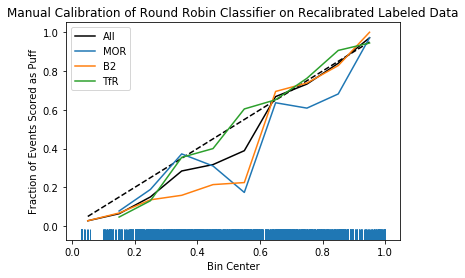

In [155]:
plt.figure()
xs = [res for res in map(np.mean, bins)]
plt.plot(xs, xs, linestyle='--', color='k')

ys = []
for idx, bin_ in enumerate(bins):
    binned_sample = redrawn_labeled_samples[(bin_[0] <= redrawn_labeled_samples['cal_proba'].values) &
                                   (redrawn_labeled_samples['cal_proba'].values < bin_[1])]
    ys.append(np.sum(binned_sample['score'] == 1)/np.sum(binned_sample['score'] >= 0))
plt.plot(xs, ys, label='All', color='k')
sns.rugplot(redrawn_labeled_samples['cal_proba'].values)

for cargo in redrawn_labeled_samples['cargo'].unique():
    ys = []
    for idx, bin_ in enumerate(bins):
        binned_sample = redrawn_labeled_samples[(bin_[0] <= redrawn_labeled_samples['cal_proba'].values) &
                                       (redrawn_labeled_samples['cal_proba'].values < bin_[1]) &
                                       (redrawn_labeled_samples['cargo'] == cargo)]
        ys.append(np.sum(binned_sample['score'] == 1)/np.sum(binned_sample['score'] >= 0))
    plt.plot(xs, ys, label=cargo)
    
plt.legend()
plt.xlabel('Bin Center')
plt.ylabel('Fraction of Events Scored as Puff')
plt.title('Manual Calibration of Round Robin Classifier on Recalibrated Labeled Data')
plt.show()

In [160]:
redrawn_labeled_samples.columns

Index(['cell', 'particle', 'cal_proba', 'cargo', 'score'], dtype='object')

In [180]:
# code to generate labeled csv
fields = ['cell', 'particle']
list_of_events = pd.concat([redrawn_labeled_samples[fields],
                            binned_labeled_samples[fields]])
list_of_events = list_of_events.drop_duplicates()

intens_list = []
for cell in list_of_events['cell'].unique():
    intensities = pd.read_csv(labeled_dir + os.sep + cell + '_intensities.csv')
    particles = list_of_events.loc[list_of_events['cell'] == cell, 'particle'].values
    intens_subset = intensities.loc[np.isin(intensities['particle'],particles), :]
    intens_list.append(intens_subset)

In [199]:
cell_id = np.hstack([np.repeat(cell, len(intens_list[i])) for i, cell in enumerate(list_of_events['cell'].unique())])

In [200]:
intens_list = pd.concat(intens_list)
intens_list['cell'] = cell_id

In [201]:
intens_list.to_csv('intens_for_calibration.csv')

In [166]:
cell = list_of_events['cell'].unique()[0]
intensities = pd.read_csv(labeled_dir + os.sep + cell + '_intensities.csv')
particles = list_of_events.loc[list_of_events['cell'] == cell, 'particle'].values

In [177]:
list_of_events['adj_proba'] = [labeled_samples.loc[(labeled_samples['cell'] == cell) &
                                                  (labeled_samples['particle'] == particle),'adj_proba'].values[0]
                              for (cell, particle) in list_of_events.itertuples(index=False, name=None)]

In [179]:
list_of_events.to_csv('events_for_calibration.csv')

In [169]:
intens_subset = intensities.loc[np.isin(intensities['particle'],particles), :]

In [171]:
len(intens_subset)/len(intensities)

0.11981629528831433